In [1]:
include("../Assignment 1/NetworkProcessing.jl")
include("../Assignment 2/NetworkModels.jl")
using Graphs
using Random
using DataStructures
using Statistics
using Setfield
using CSV
using Plots

In [2]:
graph, edge_weights, vertex_labels  = NetworkProcessing.read_network("../Assignment 1/A1-networks/model/SF_500_g2.7.net")

(SimpleGraph{Int64}(859, [[233, 399], [85, 132, 151], [43, 59], [45, 104, 167, 213, 419], [58, 129, 383, 486], [227, 465], [158, 449], [419, 499], [112, 385, 431], [109, 248]  …  [140, 492], [61, 491], [189, 197, 418], [101, 278, 342, 446], [33, 41], [131, 193, 411], [252, 392, 476], [64, 465], [8, 432], [38, 67, 141, 295, 297, 307, 341, 409, 410]]), Dict((12, 439) => 1.0, (2, 151) => 1.0, (88, 490) => 1.0, (221, 400) => 1.0, (161, 462) => 1.0, (254, 293) => 1.0, (188, 371) => 1.0, (19, 157) => 1.0, (12, 126) => 1.0, (154, 213) => 1.0…), Dict{Int64, AbstractString}(56 => "55", 35 => "34", 425 => "424", 429 => "428", 60 => "59", 220 => "219", 308 => "307", 67 => "66", 215 => "214", 73 => "72"…))

In [32]:
abstract type Model end

struct SIS <: Model
    μ::Float64 
    β::Float64
    network::Graphs.SimpleGraphs.SimpleGraph{Int64}
    timeStep::Int64
    verticesState::Vector{Bool}
end
μ(s::SIS) = s.μ 
β(s::SIS) = s.β
network(s::SIS) = s.network
timeStep(s::SIS) = s.timeStep
verticesState(s::SIS) = s.verticesState

function create_SIS(graph, μ::AbstractFloat, β::AbstractFloat, p::AbstractFloat)
    v = rand!(zeros(nv(graph)))
    verticesState = [i < p for i in v]
    return SIS(μ, β, graph, 0, verticesState)
end

function update_SIS(m::Model)
    m = @set m.timeStep += 1
    for vertex in vertices(m.network)
        if m.verticesState[vertex] == 1 && rand() <= m.μ
            m = @set m.verticesState[vertex] = 0
        else
            for neighbor in neighbors(m.network, vertex)
                if rand() <= m.β
                    m = @set m.verticesState[vertex] = 1
                    break
                end
            end    
        end
    end 
    return m
end

function monte_carlo(N_rep::Int64, T_max::Int64, T_trans::Int64, initParams::Dict{String,Any})
    ps_reps = []
    for rep in 1:N_rep
        sis = create_SIS(initParams["graph"], initParams["μ"], initParams["β"], initParams["p0"])
        ps_steps = []
        for step in 1:T_max
            if step == 1
                print(counter(sis.verticesState)[1]/size(sis.verticesState)[1])
            end
            sis = update_SIS(sis)
            if step == 1
                print(counter(sis.verticesState)[1]/size(sis.verticesState)[1])
            end
            if step < T_trans
                push!(ps_steps, counter(sis.verticesState)[1]/size(sis.verticesState)[1])
            end
        end
        push!(ps_reps,mean(ps_steps))
    end
    print(ps_reps)
    return mean(ps_reps)
end

allcombinations(v...) = vec(collect(Iterators.product(v...)))

allcombinations (generic function with 1 method)

In [9]:
baseDir = "networks/"
resultsDir = "results/"
μs = [0.1,0.5,0.9]
βs = LinRange(0,1,51)
networks = readdir(baseDir * "toy")
net_results = Dict{Int64, Vector}()
print("--- > Processing Networks:")
for (i,network) in enumerate(networks[1:2])
    print("\n - > $network")
    graph, edge_weights, vertex_labels  = NetworkProcessing.read_network("../Assignment 1/A1-networks/toy/$network")
    temp_res = Dict{AbstractFloat, Dict{String, Vector{Float64}}}()
    for (j,comb) in enumerate(allcombinations(βs, μs))
        initParams = Dict("graph"=>graph,"μ"=>comb[2], "β"=>comb[1], "p0"=>0.2)
        p = monte_carlo(100, 1000, 900, initParams)
        if j %51 == 1
            temp_res[comb[2]] = Dict("p"=>[p], "β"=>[comb[1]])
        else
            append!(temp_res[comb[2]]["p"], [p])
            append!(temp_res[comb[2]]["β"], [comb[1]])
        end
        net_results[i*j] = [network, comb[2], comb[1], p]
    end
    for (i, (μ, dict)) in enumerate(temp_res)
        if i == 1
            plot(dict["β"],dict["p"], marker=:cirlce, label=μ, title=network)
        else
            plot!(dict["β"],dict["p"], marker=:cirlce, label=μ)
        end
    end
    savefig(resultsDir * "/$network.png")
end

df = NetworkProcessing.construct_df(net_results, ["network","μ","β","p"])

CSV.write("Exercise_Results.csv", df)

--- > Processing Networks: - > 20x2+5x2.net - > circle9.net

┌ Warning: Skipped marker arg cirlce.
└ @ Plots C:\Users\mario\.julia\packages\Plots\ju9dp\src\args.jl:1149
┌ Warning: Skipped marker arg cirlce.
└ @ Plots C:\Users\mario\.julia\packages\Plots\ju9dp\src\args.jl:1149
┌ Warning: Skipped marker arg cirlce.
└ @ Plots C:\Users\mario\.julia\packages\Plots\ju9dp\src\args.jl:1149
┌ Warning: Skipped marker arg cirlce.
└ @ Plots C:\Users\mario\.julia\packages\Plots\ju9dp\src\args.jl:1149
┌ Warning: Skipped marker arg cirlce.
└ @ Plots C:\Users\mario\.julia\packages\Plots\ju9dp\src\args.jl:1149
┌ Warning: Skipped marker arg cirlce.
└ @ Plots C:\Users\mario\.julia\packages\Plots\ju9dp\src\args.jl:1149


"Exercise_Results.csv"

In [122]:
allcombinations(βs,μs)

153-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.1)
 (0.02, 0.1)
 (0.04, 0.1)
 (0.06, 0.1)
 (0.08, 0.1)
 (0.1, 0.1)
 (0.12, 0.1)
 (0.14, 0.1)
 (0.16, 0.1)
 (0.18, 0.1)
 (0.2, 0.1)
 (0.22, 0.1)
 (0.24, 0.1)
 ⋮
 (0.78, 0.9)
 (0.8, 0.9)
 (0.82, 0.9)
 (0.84, 0.9)
 (0.86, 0.9)
 (0.88, 0.9)
 (0.9, 0.9)
 (0.92, 0.9)
 (0.94, 0.9)
 (0.96, 0.9)
 (0.98, 0.9)
 (1.0, 0.9)

In [118]:
for i in 1:51*3
    if i%51 == 1
        print(i)
    end
end

152103

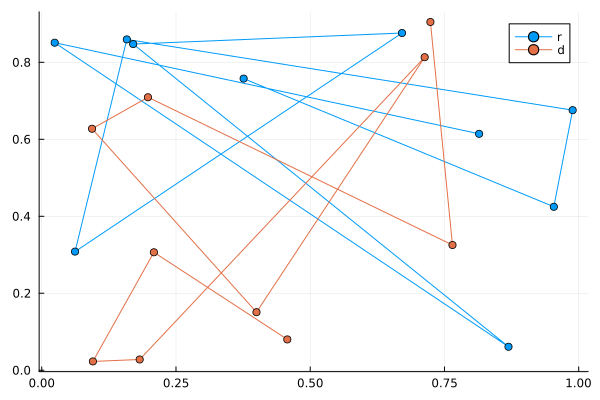

In [97]:
using Plots
r1 = rand!(zeros(10)) 
r2 = rand!(zeros(10)) 
d1 = rand!(zeros(10)) 
d2 = rand!(zeros(10)) 

plot(r1,r2, marker=:circle, label="r")
plot!(d1,d2, marker=:circle, label="d")

In [78]:
g = Dict{AbstractFloat, Dict{String, Vector{Float64}}}()

Dict{AbstractFloat, Dict{String, Vector{Float64}}}()

In [80]:
g[0.2] = Dict("p"=>[0.5], "β"=>[0.5])

Dict{String, Vector{Float64}} with 2 entries:
  "p" => [0.5]
  "β" => [0.5]

In [86]:
append!(g[0.2]["p"], [0.7])

2-element Vector{Float64}:
 0.5
 0.7

In [87]:
g[0.2]

Dict{String, Vector{Float64}} with 2 entries:
  "p" => [0.5, 0.7]
  "β" => [0.5]

In [98]:
f = 3
println("Tengo $f.perros")

Tengo 3.perros


In [65]:
readdir("../Assignment 1/A1-Networks/toy")[1:2]

2-element Vector{String}:
 "20x2+5x2.net"
 "circle9.net"

In [56]:
net_results = Dict{String, Vector}()
for dir in readdir("A1-Networks")
    for file in readdir("A1-networks/$dir")

51-element Vector{Float64}:
 0.0
 0.02
 0.04
 0.06
 0.08
 0.1
 0.12
 0.14
 0.16
 0.18
 0.2
 0.22
 0.24
 ⋮
 0.78
 0.8
 0.82
 0.84
 0.86
 0.88
 0.9
 0.92
 0.94
 0.96
 0.98
 1.0

In [72]:
for (i,n) in enumerate([10,11,12])
    print(i, n)
end

110211312

In [32]:
sis = SIS(0.5, 0.5, graph, 0, zeros(nv(graph)))

SIS(0.5, 0.5, SimpleGraph{Int64}(859, [[233, 399], [85, 132, 151], [43, 59], [45, 104, 167, 213, 419], [58, 129, 383, 486], [227, 465], [158, 449], [419, 499], [112, 385, 431], [109, 248]  …  [140, 492], [61, 491], [189, 197, 418], [101, 278, 342, 446], [33, 41], [131, 193, 411], [252, 392, 476], [64, 465], [8, 432], [38, 67, 141, 295, 297, 307, 341, 409, 410]]), 0, Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
sis = @set sis.μ = 0.2

SIS(0.2, 0.5, SimpleGraph{Int64}(859, [[233, 399], [85, 132, 151], [43, 59], [45, 104, 167, 213, 419], [58, 129, 383, 486], [227, 465], [158, 449], [419, 499], [112, 385, 431], [109, 248]  …  [140, 492], [61, 491], [189, 197, 418], [101, 278, 342, 446], [33, 41], [131, 193, 411], [252, 392, 476], [64, 465], [8, 432], [38, 67, 141, 295, 297, 307, 341, 409, 410]]), 0, Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
allcombinations(v...) = vec(collect(Iterators.product(v...)))


allcombinations (generic function with 1 method)

In [66]:
allcombinations([0.3,0.5,0.8], [0.2,0.6,0.9])[1] + (0.2)

LoadError: MethodError: no method matching +(::Tuple{Float64, Float64}, ::Float64)

[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:587[24m[39m
[0m  +([91m::Complex{Bool}[39m, ::Real)
[0m[90m   @[39m [90mBase[39m [90m[4mcomplex.jl:320[24m[39m
[0m  +([91m::Missing[39m, ::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:123[24m[39m
[0m  ...


In [13]:
nv(graph)

500

In [67]:
initParams = Dict("graph"=>graph,"μ"=>0.9, "β"=>0.9, "p0"=>0.2)

Dict{String, Any} with 4 entries:
  "μ"     => 0.9
  "p0"    => 0.2
  "graph" => SimpleGraph{Int64}(859, [[233, 399], [85, 132, 151], [43, 59], [45…
  "β"     => 0.9

In [70]:
monte_carlo(1, 1000, 900, initParams)

0.5248921023359278

In [100]:
using Statistics
mean([1,2,3,4,5])

3.0

In [6]:
sis1 = SIS(0.4, 0.8, graph, 0, zeros(nv(graph)))

SIS(0.4, 0.8, SimpleGraph{Int64}(859, [[233, 399], [85, 132, 151], [43, 59], [45, 104, 167, 213, 419], [58, 129, 383, 486], [227, 465], [158, 449], [419, 499], [112, 385, 431], [109, 248]  …  [140, 492], [61, 491], [189, 197, 418], [101, 278, 342, 446], [33, 41], [131, 193, 411], [252, 392, 476], [64, 465], [8, 432], [38, 67, 141, 295, 297, 307, 341, 409, 410]]), 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [11]:
5==5 && 7==6

false

In [7]:
sis1.vert = 5

LoadError: type SIS has no field vert

In [15]:
nv(graph)

502

In [9]:
add_vertices!(graph, 1)

1

In [14]:
initiate_SIS(sis1)

1

In [54]:
typeof([1.2,2.4])

Vector{Float64} (alias for Array{Float64, 1})

In [23]:
using Random
using DataStructures

count = 0
for i in 1:100
    v = rand!(zeros(100))
    rp = [i < 0.2 for i in v]
    count += counter(rp)[1]
end
count/100

19.18

In [94]:
v = rand!(zeros(150))
rp = [i < 0.2 for i in v]
counter(rp)[1]/150

0.23333333333333334

In [34]:
using DataStructures
rp = [i < 0.2 for i in v]
counter(rp)[1]

17

In [53]:
vertices(graph)[502]

502

In [ ]:
monte_carlo_SIS()

In [16]:
typeof(1.0)

Float64

In [15]:
graph, edge_weights, vertex_labels  = NetworkProcessing.read_network("NatNets/ER_500_05.net")

(SimpleGraph{Int64}(62203, [[6, 8, 9, 10, 12, 13, 15, 16, 20, 23  …  477, 478, 479, 486, 487, 488, 490, 491, 497, 498], [6, 7, 8, 10, 12, 19, 20, 23, 24, 26  …  478, 481, 485, 486, 487, 491, 492, 494, 495, 499], [4, 6, 7, 9, 11, 12, 14, 16, 18, 20  …  484, 487, 488, 489, 490, 491, 492, 493, 496, 498], [3, 6, 8, 11, 13, 15, 17, 18, 24, 25  …  479, 484, 487, 489, 490, 492, 495, 496, 498, 500], [7, 8, 9, 11, 15, 16, 17, 18, 19, 20  …  487, 488, 490, 491, 492, 493, 496, 497, 498, 500], [1, 2, 3, 4, 7, 11, 13, 14, 15, 16  …  483, 486, 487, 488, 489, 490, 492, 494, 499, 500], [2, 3, 5, 6, 9, 10, 12, 13, 14, 15  …  482, 485, 487, 490, 494, 496, 497, 498, 499, 500], [1, 2, 4, 5, 9, 10, 11, 12, 13, 17  …  484, 485, 486, 489, 492, 493, 495, 497, 498, 499], [1, 3, 5, 7, 8, 10, 11, 14, 16, 18  …  484, 485, 488, 489, 490, 491, 493, 494, 498, 499], [1, 2, 7, 8, 9, 11, 14, 16, 17, 18  …  478, 479, 482, 483, 484, 486, 487, 490, 498, 500]  …  [1, 2, 3, 5, 9, 11, 12, 13, 18, 20  …  482, 484, 485, 487, 4

In [33]:
initParams = Dict("graph"=>graph,"μ"=>0.5, "β"=>0.1, "p0"=>0.2)
monte_carlo(10, 1000, 900, initParams)

0.1880.9020.2060.8940.2240.8860.1960.9180.1980.9120.1720.9260.2180.8880.1740.9040.1860.920.210.876Any[0.6670878754171308, 0.6670255839822028, 0.6672502780867636, 0.666271412680757, 0.6676551724137936, 0.6667208008898777, 0.6673904338153509, 0.6663270300333701, 0.6668164627363737, 0.6665695216907688]

0.6669114571746388